# 1. Starter code

## 1.1. Data setup

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import json

names = json.loads(open("../data/names.txt", "r").read())
names = names["payload"]["blob"]["rawLines"]
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
print("Length of dataset: ", len(names))

Length of dataset:  32033


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(names))))
chtoi = {ch:i+1 for i, ch in enumerate(chars)}
chtoi["."] = 0
itoch = {i:ch for ch, i in chtoi.items()}
vocab_size = len(chtoi)
print("chtoi: ", chtoi)
print("itoch: ", itoch)
print("vocab_size: ", vocab_size)

chtoi:  {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itoch:  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab_size:  27


In [5]:
import random

def build_dataset(data, mode="tr", context_len=3):
  """
  Builds the dataset from the given list of words.
  
  Args:
    data (list): list of words to use
    mode (str): mode of the dataset (default: "tr" for training)
    context_len (int): length of the context window (default: 3)
  """
  
  X, y = [], []
  
  for word in data:
    context = [0] * context_len
    for ch in word + ".":
      ix = chtoi[ch]
      X.append(context)
      y.append(ix)
      context = context[1:] + [ix]
  
  X = torch.tensor(X)
  y = torch.tensor(y)
  
  print(f"X{mode}.shape: {X.shape}, y{mode}.shape: {y.shape}")
  return X, y


random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

Xtr, ytr = build_dataset(names[:n1])
Xval, yval = build_dataset(names[n1:n2], mode="val")
Xte, yte = build_dataset(names[n2:], mode="te")

Xtr.shape: torch.Size([182377, 3]), ytr.shape: torch.Size([182377])
Xval.shape: torch.Size([22857, 3]), yval.shape: torch.Size([22857])
Xte.shape: torch.Size([22912, 3]), yte.shape: torch.Size([22912])


In [6]:
for X, y in zip(Xtr[:5], ytr[:5]):
  print("".join(itoch[ix.item()] for ix in X), ">", itoch[y.item()])

... > a
..a > m
.am > r
amr > o
mro > m


## 1.2. Neural-layer classes definition

This segment reimplements the neural-layer classes from the previous notebooks and defines an API quite similar to PyTorch's.

In [7]:
import math

class Sequential:
  def __init__(self, name, layers):
    self.name = name
    self.layers = layers

  def __repr__(self):
    return self.name
    
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def params(self):
    return [p for layer in self.layers for p in layer.params()]

class Embedding:
  def __init__(self, vocab_size, emb_size):
    self.weight = torch.randn(vocab_size, emb_size) / math.sqrt(emb_size)

  def __repr__(self):
    return f"Embedding({self.weight.shape})"

  def __call__(self, x):
    self.out = self.weight[x]
    return self.out

  def params(self):
    return [self.weight]
  
class Flatten:
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out
  
  def __repr__(self):
    return f"Flatten({self.out.shape})"

  def params(self):
    return []
  
class Linear:
  """
  This layer applies a linear transformation to its input, expressed as
  y = x @ W + b, where x is the input, W is the weight matrix and b is the bias.
  This layer is also known as a fully connected layer or a dense layer.
  """
  def __init__(self, fan_in, fan_out, kaiming=True, scaling=False, bias=True):
    self.gain = 5.0 / 3.0
    self.weight = torch.randn(fan_in, fan_out) / math.sqrt(fan_in)
    self.weight = self.weight * self.gain if kaiming else self.weight
    self.weight = self.weight * 0.1 if scaling else self.weight
    self.bias = torch.zeros(fan_out) if bias else None

  def __repr__(self):
    return f"Linear({self.weight.shape}, {None if self.bias is None else self.bias})"

  def __call__(self, x):
    self.out = x @ self.weight
    self.out = self.out + self.bias if self.bias is not None else self.out
    return self.out

  def params(self):
    return [self.weight, self.bias] if self.bias is not None else [self.weight]
  
class BatchNorm:
  """
  This layer applies batch normalization to its input, which is a technique
  that normalizes the input to the layer, in order to make the training process
  more stable and faster.
  """
  def __init__(self, dim, eps=1e-5, momentum=0.01):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    self.gamma = torch.ones((1, dim))                  # aka scale
    self.beta = torch.zeros((1, dim))                  # aka shift

    # running statistics buffers
    self.running_mean = torch.zeros((1, dim))
    self.running_var = torch.ones((1, dim))

  def __repr__(self):
    return f"BatchNorm({self.gamma.shape}, {self.beta.shape})"

  def __call__(self, x):
    # forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True)                  # batch mean
      xvar = x.var(0, keepdim=True)                    # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    
    x_hat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize
    self.out = self.gamma * x_hat + self.beta          # scale and shift

    # update buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

    return self.out

  def params(self):
    return [self.gamma, self.beta]
  
class Tanh:
  """
  This layer applies an activation function (the hyperbolic tangent) element-wise
  to its input.
  """
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  
  def __repr__(self):
    return f"Tanh({self.out})"

  def params(self):
    return []

## 1.3. Neural network initialization

In [8]:
n_embd = 10
n_hidden = 200
context_len = 3

base_model = Sequential("base-model", [
  Embedding(vocab_size, n_embd), Flatten(), 
  Linear(n_embd * context_len, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size, scaling=True)
])

In [9]:
print("Number of parameters: ", sum(p.nelement() for p in base_model.params()))
for p in base_model.params():
  p.requires_grad = True

Number of parameters:  12097


## 1.4. Optimization step

In [10]:
max_steps = 200_000
batch_size = 32
lossi = []

for step in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, yb = Xtr[ix], ytr[ix]

  # forward pass
  logits = base_model(Xb)
  loss = F.cross_entropy(logits, yb)

  # backward pass
  for p in base_model.params():
    p.grad = None
  loss.backward()

  # update params
  lr = 0.1 if step < 100_000 else 0.02
  for p in base_model.params():
    p.data += -lr * p.grad

  # track stats
  if step == 0 or (step+1) % 25_000 == 0:
    print(f"{(step+1):7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      1/ 200000: 3.3015
  25000/ 200000: 2.4104
  50000/ 200000: 2.2878
  75000/ 200000: 2.2819
 100000/ 200000: 2.4198
 125000/ 200000: 1.9077
 150000/ 200000: 2.2000
 175000/ 200000: 2.0103
 200000/ 200000: 2.3734


Text(105, 0.345, 'Learning rate decay')

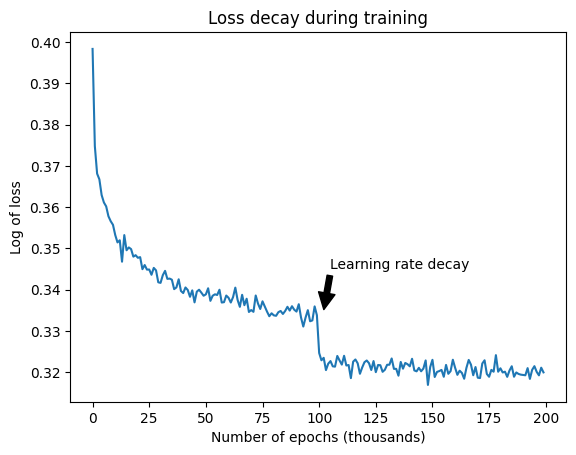

In [11]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
plt.title("Loss decay during training")
plt.xlabel("Number of epochs (thousands)")
plt.ylabel("Log of loss")

plt.annotate('Learning rate decay',
             xy=(102, 0.335),
             xytext=(105, 0.345),
             arrowprops=dict(facecolor='black', shrink=0.02)) 

## 1.5. Evaluation step

In [12]:
performance_log = {}

for layer in base_model.layers:
  layer.training = False

@torch.no_grad()
def split_loss(model):
  tr_logits = model(Xtr)
  val_logits = model(Xval)
  te_logits = model(Xte)

  performance_log[model] = {
    "context_len": context_len,
    "hidden_neurons": n_hidden,
    "params": sum(p.nelement() for p in model.params()),
    "tr_loss": round(F.cross_entropy(tr_logits, ytr).item(), 4),
    "val_loss": round(F.cross_entropy(val_logits, yval).item(), 4),
    "te_loss": round(F.cross_entropy(te_logits, yte).item(), 4),
  }

  print(performance_log)
  
split_loss(base_model)

{base-model: {'context_len': 3, 'hidden_neurons': 200, 'params': 12097, 'tr_loss': 2.0687, 'val_loss': 2.0989, 'te_loss': 2.1202}}


## 1.6. Sampling from the model

In [16]:
for _ in range(20):
  out = []
  context = [0] * context_len
  while True:
    # forward pass the neural net
    logits = base_model(torch.tensor(context).unsqueeze(0))
    probs = F.softmax(logits, dim=1)

    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1).item()

    # shift context window and track samples
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print("".join(itoch[i] for i in out))
    

kamirah.
reizabibhamillyn.
shenley.
olier.
gquinina.
freei.
mariyoha.
lyuailarimo.
kaiya.
moric.
andr.
elle.
tariah.
daita.
alizy.
moe.
ani.
mena.
jena.
jocolly.


## 2. Lazily scaling up context length

In [ ]:
Xtr, ytr = build_dataset(names[:n1], context_len=8)
Xval, yval = build_dataset(names[n1:n2], mode="val", context_len=8)
Xte, yte = build_dataset(names[n2:], mode="te", context_len=8)

In [ ]:
for X, y in zip(Xtr[:5], ytr[:5]):
  print("".join(itoch[ix.item()] for ix in X), ">", itoch[y.item()])

In [ ]:
n_embd = 10
n_hidden = 200
context_len = 8

scaled_model = Sequential("scaled-model", [
  Embedding(vocab_size, n_embd),
  Flatten(), Linear(n_embd * context_len, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size, scaling=True)
])

In [ ]:
print("Number of parameters: ", sum(p.nelement() for p in scaled_model.params()))
for p in scaled_model.params():
  p.requires_grad = True

In [ ]:
max_steps = 200_000
batch_size = 32
lossi = []

for step in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, yb = Xtr[ix], ytr[ix]

  # forward pass
  logits = scaled_model(Xb)
  loss = F.cross_entropy(logits, yb)

  # backward pass
  for p in scaled_model.params():
    p.grad = None
  loss.backward()

  # update params
  lr = 0.1 if step < 100_000 else 0.01
  for p in scaled_model.params():
    p.data += -lr * p.grad

  # track stats
  if step == 0 or (step+1) % 25_000 == 0:
    print(f"{(step+1):7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

In [ ]:
for layer in scaled_model.layers:
  layer.training = False
  
split_loss(scaled_model)

In [ ]:
for _ in range(20):
  out = []
  context = [0] * context_len
  while True:
    # forward pass the neural net
    logits = scaled_model(torch.tensor(context).unsqueeze(0))
    probs = F.softmax(logits, dim=1)

    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1).item()

    # shift context window and track samples
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print("".join(itoch[i] for i in out))

## 3. Implementing WaveNet

The architecture currently being used was proposed by [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), in which a given number of characters are fed through a single hidden layer and then the output is used to predict the next character.

<img src="../assets/neural-prob-LM.jpg" width="400"/>

Even though additional layers could be introduced, making the neural network deeper, the model would still be compressing all the information from the input into a single vector, which is then used to predict the next character.

**WaveNet**, on the other hand, is a deep generative model that is able to generate the output using a stack of dilated causal convolutions. This means that the output at a given time step is only dependent on the input at previous time steps, and the receptive field of the model grows exponentially with the number of layers.

<img src="../assets/wavenet.jpg" width="400"/>

### 3.1. Scratch space

Understanding the forward pass of the neural networks implemented previously and inspecting the shapes of the tensors being used.

In [ ]:
# construct a batch of size 4
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, yb = Xtr[ix], ytr[ix]
Xb.shape, yb.shape

In [ ]:
# output shape of the first layer of the model (the Embedding layer)
scaled_model.layers[0].out.shape

In [ ]:
# output shape of the second layer of the model (the Flatten layer)
scaled_model.layers[1].out.shape

In [ ]:
# output shape of the third layer of the model (the Linear layer)
scaled_model.layers[2].out.shape

In [ ]:
# inner operation of the third layer of the model (the Linear layer)
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

In [ ]:
# IMPORTANT: inner operation above also works with input high dimensional data (e.g. 3D)
(torch.randn(4, 5, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

In [ ]:
# in the previous models, the input characters were flattened into a single dimension
# now, we will introduce a batch dimension to fuse the characters into two-element pairs
# eg. (1, 2) (3, 4) (5, 6) (7, 8), embedded into batch_size x 2D_pairs x n_embd tensor
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

In [ ]:
# goal: reshape output of Embedding layer into a tensor of shape (4, 4, 20)
e = torch.randn(4, 8, 10)     # current architecture: (batch_size, context_len, n_embd)
exp_cat = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
exp_cat.shape

In [ ]:
(e.view(4, -1, 20) == exp_cat).all()

### 3.2. Updating the Flatten layer to include batch dimension

In [ ]:
class FlattenV2(Flatten):
  def __init__(self, n_elements):
    self.n_elements = n_elements

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T // self.n_elements, C * self.n_elements)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

In [ ]:
n_embd = 10
n_hidden = 68     # adjust hidden layer so total number of parameters is the same

wavenet_model_v1 = Sequential("wavenet-model-v1", [
  Embedding(vocab_size, n_embd),
  FlattenV2(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
  FlattenV2(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
  FlattenV2(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size, scaling=True)
])

In [ ]:
print("Number of parameters: ", sum(p.nelement() for p in wavenet_model_v1.params()))
for p in wavenet_model_v1.params():
  p.requires_grad = True

In [ ]:
logits = wavenet_model_v1(Xb)

for layer in wavenet_model_v1.layers:
  print(layer.__class__.__name__, ":", tuple(layer.out.shape))

### 3.3 Training the WaveNet: first pass

In [ ]:
max_steps = 200_000
batch_size = 32
lossi = []

for step in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, yb = Xtr[ix], ytr[ix]

  # forward pass
  logits = wavenet_model_v1(Xb)
  loss = F.cross_entropy(logits, yb)

  # backward pass
  for p in wavenet_model_v1.params():
    p.grad = None
  loss.backward()

  # update params
  lr = 0.1 if step < 100_000 else 0.01
  for p in wavenet_model_v1.params():
    p.data += -lr * p.grad

  # track stats
  if step == 0 or (step+1) % 25_000 == 0:
    print(f"{(step+1):7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

In [ ]:
for layer in wavenet_model_v1.layers:
  layer.training = False
  
split_loss(wavenet_model_v1)

In [ ]:
for _ in range(20):
  out = []
  context = [0] * context_len
  while True:
    # forward pass the neural net
    logits = wavenet_model_v1(torch.tensor(context).unsqueeze(0))
    probs = F.softmax(logits, dim=1)

    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1).item()

    # shift context window and track samples
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print("".join(itoch[i] for i in out))

# Sources

1. [Ground truth - Building makemore Part 5: Building a wavenet, By Andrej Karpathy](https://www.youtube.com/watch?v=t3YJ5hKiMQ0)
2. van den Oord, Aäron et al. WaveNet: A generative model for raw audio, 2016. URL: https://arxiv.org/abs/1609.03499
3. Torch.NN documentation: https://pytorch.org/docs/stable/nn.html